# Notebook for replicating figures from Drake et al. 2019 on the Abyssal Circulation

Note: may need to `build IJulia` in the anaconda environment that jupyter lab is launched from and `build NetCDF` before `using` it.

In [1]:
add_gsw = false
build_packages = false

if build_packages
    using Pkg
    Pkg.build("IJulia")
    Pkg.build("NetCDF")
end

dir = "../pgcm/"
using Statistics
using NetCDF
using NaNMath; nm=NaNMath
using PyCall
using PyPlot
using Interpolations
using MAT

if add_gsw
    using Conda
    Conda.add("gsw")
end
gsw = pyimport("gsw");

nanmean(a) = mean(filter(!isnan,a));
nanmean(a, dims) = mapslices(nanmean, a, dims = dims);

dpi = 75;

In [2]:
N = sqrt(1.5)*1.e-3
#layer_scale = mean(exp.(-((2500:100:5000)+z0)/1000)) # average of exponential decay of abyssal layer
H = 2500.
Htop = 2500.
B = 2.e-11
L = 6e6
Uscale = (N^2)*(H^2)/(B*L^2)*1e3
Wscale = (N^2)*(H^3)/(B*L^3)*1e3
Tscale = (N^2)*(H^3)/(B*L)*1.e-6
kscale = 5.e-2;

dt = 2.e-5
dt_recip = Int(round(dt^-1))

topo_col = (0.75,0.75,0.80);

PyCall.PyDict(matplotlib."rcParams")["font.size"]=15;


# Revisiting the Munk+ Balance

In [133]:
expname = "ridge-0.6_del-inf"
exp_label = L"$r_{h}=2000$ m, $\delta=1000$ m"

nf = 20
del = 10.
nz = 20

labels = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n"]
    
print(string("\n", expname, "\n"))
nIter = dt_recip*50

include(string(dir,expname,"/runs/equil/kernel.jl"));
m = load(string(dir,expname,"/runs/equil")) # Model setup
s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

# Interpolate all fields to cell centers before performing operations
usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

# Calculate vertical velocity from sigma coordinate velocities
uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

# Interpolate depth onto z-grid
Nsq = dscc(m,s.bc,0.)./m.hc

# Interpolate velocities onto z-grid for efficient particle tracking
nx=500; dx = 1. /nx; x_grid = 0. +dx/2.:dx:1. -dx/2.
ny=500; dy = 2. /ny; y_grid = -1. +dy/2.:dy:1. -dy/2.
nz=nz;  dz = 1. /nz; z_grid = -1. +dz/2.:dz:0. -dz/2.

# Interpolate depth onto z-grid
hc_grid = zeros(ny,nx)

knots = (m.yc[:],m.xc[:]);
itp_hc = extrapolate(interpolate(knots,hc[1,:,:], Gridded(Linear())), NaN);

for i=1:nx
    for j=1:ny
        hc_grid[j,i] = itp_hc(y_grid[j],x_grid[i])
    end 
end

Nsq_grid = zeros(nz,ny,nx)
kfs_grid = zeros(nz,ny,nx)
uzc_grid = zeros(nz,ny,nx)
land_grid = zeros(nz,ny,nx)

c_knots = (m.sc[:],m.yc[:],m.xc[:]);
f_knots = (m.sf[:],m.yc[:],m.xc[:]);
itp_Nsq = extrapolate(interpolate(c_knots,Nsq, Gridded(Linear())), NaN);
itp_kfs = extrapolate(interpolate(f_knots,m.kfs, Gridded(Linear())), NaN);
itp_uzc = extrapolate(interpolate(c_knots,uzc, Gridded(Linear())), NaN);

for i=1:nx
    for j=1:ny
        for k=1:nz
            if abs(z_grid[k])<hc_grid[j,i]
                Nsq_grid[k,j,i] = itp_Nsq(z_grid[k]/hc_grid[j,i],y_grid[j],x_grid[i])
                kfs_grid[k,j,i] = itp_kfs(z_grid[k]/hc_grid[j,i],y_grid[j],x_grid[i])
                uzc_grid[k,j,i] = itp_uzc(z_grid[k]/hc_grid[j,i],y_grid[j],x_grid[i])
                land_grid[k,j,i] = 1
            else
                Nsq_grid[k,j,i] = NaN
                kfs_grid[k,j,i] = NaN
                uzc_grid[k,j,i] = NaN
            end
        end
    end
end
    
A = sum(land_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],dims=(2,3))[:,1,1]*dx*dy;
Nsq_av = nanmean(Nsq_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];
k_av = nanmean(kfs_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];
w_av = nanmean(uzc_grid[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];
k_Nsq_av = nanmean((kfs_grid.*Nsq_grid)[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];
w_Nsq_av = nanmean((uzc_grid.*Nsq_grid)[:,2*Int(ny/4):3*Int(ny/4),Int(nx/4):3*Int(nx/4)],(2,3))[:,1,1];
    
# assert BC
A[isnan.(A)] .= 0.;
Nsq_av[isnan.(Nsq_av)] .= 0.;
k_av[isnan.(k_av)] .= 0.;
w_av[isnan.(w_av)] .= 0.;
k_Nsq_av[isnan.(k_Nsq_av)] .= 0.;
w_Nsq_av[isnan.(w_Nsq_av)] .= 0.;

A_f = 0.5*(A[2:end] .+ A[1:end-1])
Nsq_av_f = 0.5*(Nsq_av[2:end].+Nsq_av[1:end-1])
k_av_f = 0.5*(k_av[2:end].+k_av[1:end-1])
k_Nsq_av_f = 0.5*(k_Nsq_av[2:end] + k_Nsq_av[1:end-1])
    
A_k_Nsq_av_f = A_f .* k_Nsq_av_f
A_k_av_Nsq_av_f = A_f .* k_av_f .* Nsq_av_f
    
psi=zeros(nz)
psi[2:end-1] = Nsq_av[2:end-1].^(-1).*(A_k_av_Nsq_av_f[2:end]-A_k_av_Nsq_av_f[1:end-1])/dz;
psi = replace!(psi, NaN=> 0.)
psi = replace!(psi, Inf=> 0.)

psi_corr=zeros(nz)
psi_corr[2:end-1] = Nsq_av[2:end-1].^(-1).*(A_k_Nsq_av_f[2:end]-A_k_Nsq_av_f[1:end-1])/dz;
psi_corr = replace!(psi_corr, NaN=> 0.)
psi_corr = replace!(psi_corr, Inf=> 0.)

####
# Restoring
Dr = -m.cc.*(s.bc-m.bic)

# Advective fluxes
# get velocities
Ux, Uy, Us = velocities(m,s.bc)
# calculate advective fluxes
hFx = m.hfx.*Ux.*ixcf(m,s.bc)
hFy = m.hfy.*Uy.*iycf(m,s.bc)
hFs = m.hc.*Us.*iscf(m,s.bc)

# Advective flux divergence
Du = zeros(size(s.bc))
Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

# Advective flux divergences
Dux = zeros(size(s.bc))
Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

Duy = zeros(size(s.bc))
Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

Dus = zeros(size(s.bc))
Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)
    
# Buoyancy tendency 
s1 = load(string(dir,expname,"/runs/equil"),nIter+5000); # Model state
dbdt = (s1.bc-s.bc)/(m.dt*5000.)

# Diagnose diffusive flux divergence from other terms
Dk = dbdt - (Du + Dr)

sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);

x_c,y_c = 
[m.xc[i] for k in 1:1, j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:1, j in 1:length(m.yc), i in 1:length(m.xc)];
sim_ridge_mask_c = (y_c.>=0.) .& (y_c.<=0.5) .& (x_c.>0.25) .& (x_c.<0.75);

###############    Water mass transformation     ##################

mins = -1.05
dsf = round(abs(mins/(nf+1)),digits=5)
sf = reshape(mins+dsf/2:dsf:0-dsf/2, (nf+1, 1, 1))
scb = reshape(mins+dsf:dsf:0-dsf, (nf, 1, 1))

bf = del*(exp.(sf/del) .-1.)
dbf = bf[2:end]-bf[1:end-1]
bc = del*(exp.(scb/del) .-1.)
dbc = bc[2:end]-bc[1:end-1]

itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear())), NaN);
bcf = itp(sf[:,1,1], m.yc[1,:,1], m.xc[1,1,:])

dV_f = repeat((m.hc*dsf)*m.dx*m.dy, outer=[nf+1, 1, 1]);

zc = zeros(nf)
for i in 1:nf
    idx = bf[i] .< bcf .< bf[i+1]
    zc[i] = sum(idx.*dV_f.*(sf.*m.hc).*sim_ridge_mask_c)./sum(idx.*dV_f.*sim_ridge_mask_c)
end
zc[isnan.(zc)] .= -1.
zc[end] = 0.

########################################
zref = vcat(copy(zc),[0])
bref = vcat(copy(bc)[:,1,1],[0])
nref = length(bref)
intD = zeros(size(bref))

tmp = Dk.*(m.hc*m.ds)*m.dx*m.dy
intD = zeros(size(bref))
for i=1:1:nref
    intD[i] = sum(tmp[(s.bc.<=bref[i]) .& sim_ridge_mask])
end
T = diff(intD)./diff(bref) #*Tscale
T[isnan.(T)] .= 0;
    
intD_uncorr = zeros(size(bref))
for i=1:1:nref
    tmp = ones(size(Dk)).*(m.hc*m.ds)*m.dx*m.dy
    intD_uncorr[i] = sum(tmp[(s.bc.<=bref[i]) .& sim_ridge_mask])
end
T = diff(intD)./diff(bref) #*Tscale
T[isnan.(T)] .= 0;



ridge-0.6_del-inf


In [134]:
function b_average(arr, dV, b, lev_bounds, mask)
    tmp = zeros(length(lev_bounds)-1)
    for b_idx = 1:(length(lev_bounds)-1)
        idx = (b .>= lev_bounds[b_idx]) .& (b .<= lev_bounds[b_idx+1]) .& mask
        if any(idx)
            tmp[b_idx] = sum((arr.*dV)[idx]/sum(dV[idx]))
        else
            tmp[b_idx] = NaN
        end
    end
    return tmp
end
    
function b_sum(arr, b, lev, lev_bounds, mask)
    tmp = zeros(length(lev))
    for b_idx = 1:length(lev)
        b_surface = falses(size(arr))
        closest_idx = findmin(abs.(b .- lev[b_idx]), dims=1)[2]
        b_surface[closest_idx] .= true
        b_surface .= b_surface .& (b .>= lev_bounds[b_idx]) .& (b .<= lev_bounds[b_idx+1]) .& mask
        if any(b_surface) > 0
            tmp[b_idx] = sum(arr[b_surface])
        else
            tmp[b_idx] = NaN
        end
    end
    return tmp
end
    
dh = repeat(m.hc*m.ds, outer=[size(m.sc, 1), 1, 1]);
dh_f = repeat(m.hc*m.ds, outer=[size(m.sf, 1), 1, 1]);
dA = repeat([m.dx*m.dy], outer=size(s.bc));
dA_f = repeat([m.dx*m.dy], outer=size(m.kfs));
dV = repeat((m.hc*m.ds)*m.dx*m.dy, outer=[size(m.sc, 1), 1, 1]);
dV_f = repeat((m.hc*m.ds)*m.dx*m.dy, outer=[size(m.sf, 1), 1, 1]);
        
b_lev_c = bc[:, 1, 1]
b_lev_c_extend = cat(b_lev_c[1]-(b_lev_c[2] - b_lev_c[1]), b_lev_c, b_lev_c[end]+(b_lev_c[end] - b_lev_c[end-1]), dims=1)
b_lev_f = bf[:, 1, 1]
b_average(s.bc, dV, s.bc, b_lev_f, sim_ridge_mask);

Calculate $A^{b}$, $\langle \kappa \rangle$, $\langle b_{z} \rangle$, $\langle \kappa b_{z} \rangle$ at $b$-cell centers and $A^{b}$, $\langle \kappa \rangle$, $\langle b_{z} \rangle$, $\langle \kappa' b_{z}' \rangle$ at $b$-cell faces.

In [135]:
# Define b grid
kc = zeros(size(s.bc))
kc[2:end-1,:,:] .= ((m.kfs[1:end-1,:,:] .+ m.kfs[2:end,:,:])/2.)

A_bav_c = b_sum(dA, s.bc, b_lev_c, b_lev_f, sim_ridge_mask);
k_bav_c = b_average(kc, dV, s.bc, b_lev_f, sim_ridge_mask)
bz_bav_c = b_average(Nsq, dV, s.bc, b_lev_f, sim_ridge_mask)
k_bz_bav_c = b_average((kc.*Nsq), dV, s.bc, b_lev_f, sim_ridge_mask)

A_bav_f = b_sum(dA, s.bc, b_lev_f, b_lev_c_extend, sim_ridge_mask);
k_bav_f = b_average(kc, dV, s.bc, b_lev_c_extend, sim_ridge_mask)
bz_bav_f = b_average(Nsq, dV, s.bc, b_lev_c_extend, sim_ridge_mask)
k_bz_bav_f = b_average((kc.*Nsq), dV, s.bc, b_lev_c_extend, sim_ridge_mask)

z_bav_c = b_average((m.sc.*m.hc), dV, s.bc, b_lev_f, sim_ridge_mask)

kp_bzp_bav_f = zeros(length(b_lev_c_extend)-1)
for b_idx = 1:(length(b_lev_c_extend)-1)
    idx = (s.bc .>= b_lev_c_extend[b_idx]) .& (s.bc .<= b_lev_c_extend[b_idx+1]) .& sim_ridge_mask
    arr = (kc .- k_bav_f[b_idx]) .* (Nsq .- bz_bav_f[b_idx])
    if any(idx)
        kp_bzp_bav_f[b_idx] = sum((arr.*dV)[idx]/sum(dV[idx]))
    else
        kp_bzp_bav_f[b_idx] = NaN
    end
end

In [136]:
all_terms = diff(A_bav_f .* k_bz_bav_f)./diff(b_lev_f)
dA_db_term = k_bz_bav_c .* diff(A_bav_f)./diff(b_lev_f)
dbz_db_term = A_bav_c .* k_bav_c .* diff(bz_bav_f)./diff(b_lev_f)
dk_db_term = A_bav_c .* bz_bav_c .* diff(k_bav_f)./diff(b_lev_f)
dkpbzp_db_term = A_bav_c .* diff(kp_bzp_bav_f)./diff(b_lev_f);

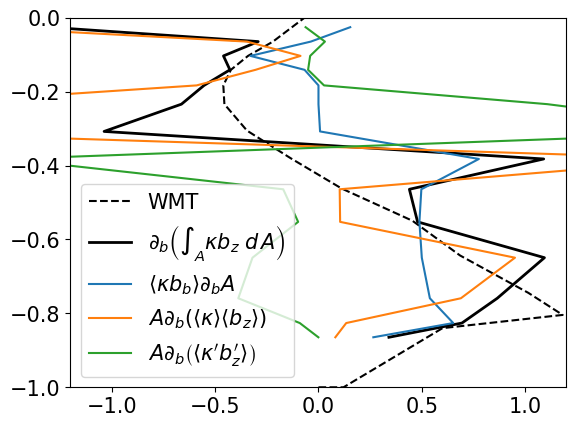

(-1, 0)

In [137]:
plot(T*Tscale, zc, "k--", label = "WMT")
plot(all_terms*Tscale, z_bav_c, "k-", lw=2.,
    label=L"$ \partial_{b} \left ( \int_{A} \kappa b_{z} \; d\, A \right)$")
plot(dA_db_term*Tscale, z_bav_c, label=L"$ \langle \kappa b_{b} \rangle \partial_{b} A$")
plot((dk_db_term+dbz_db_term)*Tscale, z_bav_c, label=L"$A \partial_{b} \left( \langle \kappa \rangle \langle b_{z} \rangle \right)$")
plot(dkpbzp_db_term*Tscale, z_bav_c, label=L"$A \partial_{b} \left( \langle \kappa' b_{z}' \rangle \right)$")
#plot(dbz_db_term, zc, label="diff")
#plot(dk_db_term, zc, label="$A \langle b_{z} \rangle \$")
legend()
xlim([-1.2, 1.2])
ylim([-1, 0])

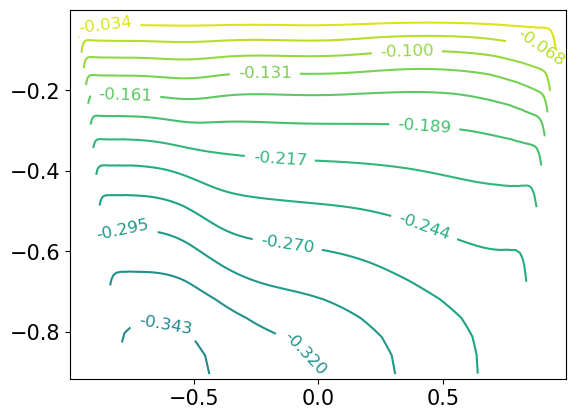

12-element Array{PyObject,1}:
 PyObject Text(-0.615, -0.7819426026913494, '-0.343')               
 PyObject Text(-0.05499999999999994, -0.8530201359766225, '-0.320') 
 PyObject Text(-0.785, -0.5464758119803993, '-0.295')               
 PyObject Text(-0.125, -0.5821821864117027, '-0.270')               
 PyObject Text(0.4249999999999998, -0.5387479184474152, '-0.244')   
 PyObject Text(-0.1549999999999998, -0.37019725318097074, '-0.217') 
 PyObject Text(0.42500000000000004, -0.2879476034961027, '-0.189')  
 PyObject Text(-0.775, -0.21194800594340646, '-0.161')              
 PyObject Text(-0.21499999999999986, -0.15769281717360817, '-0.131')
 PyObject Text(0.355, -0.10327617892389884, '-0.100')               
 PyObject Text(0.8906294302227913, -0.09390516184516928, '-0.068')  
 PyObject Text(-0.8549999999999998, -0.03786440029199434, '-0.034') 

In [37]:
CS = contour(yc[:,:,25], (m.hc.*m.sc)[:,:,25], s.bc[:,:,25], levels=b_lev_c)
clabel(CS, inline=1, fontsize=12)

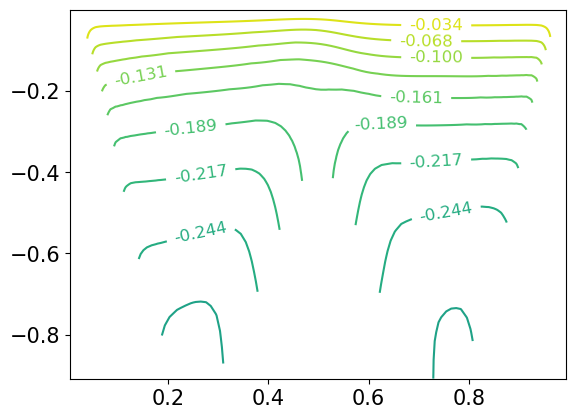

11-element Array{PyObject,1}:
 PyObject Text(0.26500000000000007, -0.548735199846605, '-0.244')  
 PyObject Text(0.755, -0.499306089227757, '-0.244')                
 PyObject Text(0.26500000000000007, -0.40637021991996203, '-0.217')
 PyObject Text(0.735, -0.374578638119318, '-0.217')                
 PyObject Text(0.24500000000000005, -0.29175926421133713, '-0.189')
 PyObject Text(0.6250000000000001, -0.2814316284533367, '-0.189')  
 PyObject Text(0.6950000000000001, -0.21769087997245695, '-0.161') 
 PyObject Text(0.14500000000000002, -0.16440732656847568, '-0.131')
 PyObject Text(0.7349999999999999, -0.11829939684104385, '-0.100') 
 PyObject Text(0.7150000000000001, -0.07738723957807281, '-0.068') 
 PyObject Text(0.735, -0.038720683832793146, '-0.034')             

In [38]:
CS = contour(xc[:,150,:], (m.hc.*m.sc)[:,150,:], s.bc[:,150,:], levels=b_lev_c)
clabel(CS, inline=1, fontsize=12)

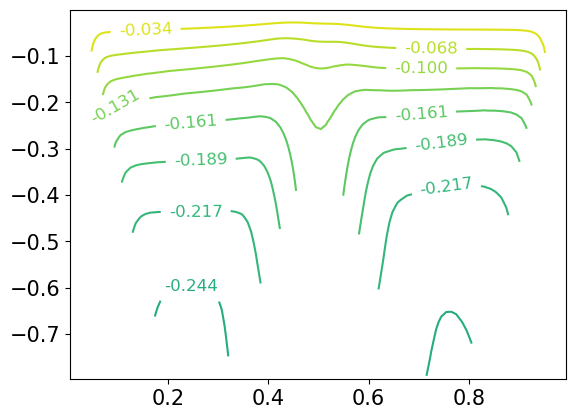

11-element Array{PyObject,1}:
 PyObject Text(0.24500000000000005, -0.5980519437222213, '-0.244') 
 PyObject Text(0.25500000000000006, -0.43786583768327475, '-0.217')
 PyObject Text(0.755, -0.3826905455225743, '-0.217')               
 PyObject Text(0.26500000000000007, -0.32542662992366234, '-0.189')
 PyObject Text(0.7450000000000001, -0.28814403952527934, '-0.189') 
 PyObject Text(0.24500000000000005, -0.24392597341211464, '-0.161')
 PyObject Text(0.705, -0.22649407120906018, '-0.161')              
 PyObject Text(0.09500000000000003, -0.20910388536497526, '-0.131')
 PyObject Text(0.705, -0.12739208288564052, '-0.100')              
 PyObject Text(0.7250000000000001, -0.08445928941399894, '-0.068') 
 PyObject Text(0.15500000000000003, -0.04473109847912671, '-0.034')

In [39]:
CS = contour(xc[:,180,:], (m.hc.*m.sc)[:,180,:], s.bc[:,180,:], levels=b_lev_c)
clabel(CS, inline=1, fontsize=12)

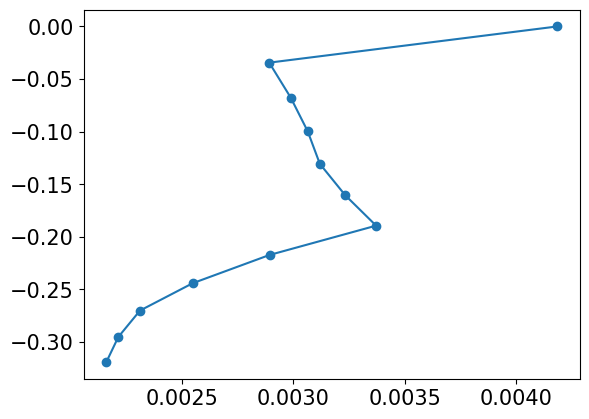

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x2aab1c5a5710>

In [108]:
plot(A_bav_c, b_lev_c, "C0-o")

In [ ]:
# ######### DIFFUSIVE FLUXES ###########
# kc = zeros(size(s.bc))
# kc[2:end-1,:,:] = ((m.kfs[1:end-1,:,:] .+ m.kfs[2:end,:,:])/2.)

# # Explicit vertical flux divergence
# hFs = -m.kfs./m.hc.*iscf(m,dscc(m,s.bc,0))
# Dkz = zeros(size(s.bc))
# Dkz[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
# Dkz[2:m.ns,:,:] += hFs./(m.hc*m.ds)

# # Interpolate depth onto z-grid
# Nsq = dscc(m,s.bc,0.)./m.hc
# Nsq_cart = zeros(size(Nsq))
# kfs_cart = zeros(size(m.kfs))
# land_cart = zeros(size(Nsq))

# knots = (m.sc[:],m.yc[:],m.xc[:]);
# itp_Nsq = extrapolate(interpolate(knots, Nsq, Gridded(Linear())), NaN);
# knots = (m.sf[:],m.yc[:],m.xc[:]);
# itp_kfs = extrapolate(interpolate(knots, m.kfs, Gridded(Linear())), NaN);

# for i=1:m.nx
#     for j=1:m.ny
#         for k=1:m.ns
#             if -m.sc[k]<=m.hc[1,j,i]
#                 Nsq_cart[k,j,i] = itp_Nsq(m.sc[k]./m.hc[1,j,i],m.yc[j],m.xc[i])
#                 land_cart[k,j,i] = 1
#             else
#                 Nsq_cart[k,j,i] = NaN
#             end
#         end
#     end
# end

# for i=1:m.nx
#     for j=1:m.ny
#         for k=1:m.ns-1
#             if -m.sf[k]<m.hc[1,j,i]
#                 kfs_cart[k,j,i] = itp_kfs(m.sf[k]./m.hc[1,j,i],m.yc[j],m.xc[i])
#             else
#                 kfs_cart[k,j,i] = NaN
#             end
#         end
#     end
# end

# Nsq_cart_av = nanmean(Nsq_cart[:,100:150,27:73], (2,3))[:,1,1];
# k_cart_av = nanmean(kfs_cart[:,100:150,27:73], (2,3))[:,1,1];
# A_cart = sum(land_cart[:,100:150,27:73], dims=(2,3))[:,1,1]*m.dx*m.dy;

# psi = zeros(m.ns-2);
# Nsq_f = 0.5.*(Nsq_cart_av[2:end] .+ Nsq_cart_av[1:end-1])
# kNsq_f = k_cart_av.*Nsq_f

# psi_munk = (A_cart./Nsq_cart_av)[2:end-1] .* (kNsq_f[2:end].-kNsq_f[1:end-1])/m.ds

# Nsqav = zeros(size(Nsq))

# knots = (m.sc[:],)
# itp_Nsqav = extrapolate(interpolate(knots, nanmean(Nsq_cart[:,100:end,:],(2,3))[:,1,1], Gridded(Linear())), NaN);

# for i=1:m.nx
#     for j=1:m.ny
#         for k=1:m.ns
#             Nsqav[k,j,i] = itp_Nsqav(m.sc[k].*m.hc[1,j,i])
#         end
#     end
# end
# Nsqav[isnan.(Nsqav)] .= 0.
# kc = zeros(size(Nsqav))
# kc[2:end-1,:,:] = ((m.kfs[1:end-1,:,:].+m.kfs[2:end,:,:])/2.)

# Dkav = kc.*dscc(m,Nsqav,0)./m.hc


In [ ]:
figure(figsize=(14,5))

ax = subplot(1,4,1)
plot(Nsq_av*N^2*1.e6,z_grid*(-H) .+Htop,lw=2)
ylabel("depth [m]")
xlabel(L"stratification $\langle N^{2} \rangle$ [10$^{-6}$ s$^{-2}$]");
xlim([0,1.75])
xticks([0.,0.5,1.0,1.5])
ylim([5000,2500])
grid(true)
bbox_props = Dict("boxstyle" => "square,pad=0.12", "fc" => "w", "ec" => "0.5", "alpha" => 0.5)
ax.annotate(s=exp_label,xy=(0.02,0.91),xycoords="axes fraction",fontsize=15,bbox=bbox_props)

ax = subplot(1,4,2)
plot(k_av*kscale*1.e4,z_grid*(-H) .+Htop,lw=2)
xlim([0,15])
xticks([0,5,10,15])
ylabel(""); ax.tick_params(labelleft=false);
xlabel(L"diffusivity $\langle \kappa \rangle$ [10$^{-4}$ m$^{2}$s$^{-1}$]")
ylim([5000,2500])
grid(true)

ax = subplot(1,4,3)
plot(A*L^2*1.e-12,z_grid*(-H) .+Htop,lw=2)
ylabel(""); ax.tick_params(labelleft=false);
xlabel(L"surface area [10$^{6}$ km$^{2}$]")
xlim([0,10])
xticks([0,2.5,5,7.5,10],["0","2.5","5","7.5","10"])
ylim([5000,2500])
grid(true)

ax = subplot(1,4,4)
plot(psi*Tscale,z_grid*(-H) .+Htop,label="MW98","C0--",lw=2)
plot(w_av.*A*Tscale,z_grid*(-H) .+Htop,label=L"$\langle w\rangle A$","k--",lw=2)
plot((w_Nsq_av./Nsq_av).*A.*Tscale,z_grid*(-H) .+Htop,label=L"$\langle w N^{2}\rangle / \langle N^{2} \rangle A$","k:",lw=2)
plot(T*Tscale,0.5*(zref[1:end-1]+zref[2:end])*(-H) .+Htop,label=L"$T_{net}$","k-",lw=2)
ylabel(""); ax.tick_params(labelleft=false);
xlabel("transport [Sv]")
xlim([-3.2,3.2])
xticks([-2,-1,0,1,2])
ylim([5000,2500])
grid(true)
legend(loc="lower left",handlelength=0.9,labelspacing=0.2);

tight_layout()
for panel_idx=1:4
    ax=subplot(1,4,panel_idx)
    ax.annotate(s=labels[panel_idx],xy=(0.93,0.032),xycoords="axes fraction",fontsize=14)
end

savefig(string("../figures/Munk.png"),dpi=dpi,bbox_inches="tight")

In [ ]:
figure(figsize=(14,5))

ax = subplot(1,4,1)
plot(Nsq_av*N^2*1.e6,z_grid*(-H) .+Htop,lw=2)
ylabel("depth [m]")
xlabel(L"stratification $\langle N^{2} \rangle$ [10$^{-6}$ s$^{-2}$]");
xlim([0,1.75])
xticks([0.,0.5,1.0,1.5])
ylim([5000,2500])
grid(true)
bbox_props = Dict("boxstyle" => "square,pad=0.12", "fc" => "w", "ec" => "0.5", "alpha" => 0.5)
ax.annotate(s=exp_label,xy=(0.02,0.91),xycoords="axes fraction",fontsize=15,bbox=bbox_props)

ax = subplot(1,4,2)
plot(Nsq_av.*k_av*kscale*N^2*1.e10,z_grid*(-H) .+Htop, "C0--", lw=2, label=L"$\langle \kappa \rangle \langle N^{2} \rangle$")
plot(k_Nsq_av*kscale*N^2*1.e10,z_grid*(-H) .+Htop, "C0-", lw=2, label=L"$\langle \kappa N^{2} \rangle$")
xlim([0,2.0])
xticks([0,0.5,1.0,1.5,2.0])
ylabel(""); ax.tick_params(labelleft=false);
xlabel(L"buoyancy flux [10$^{-10}$ m$^{2}$s$^{-3}$]")
ylim([5000,2500])
legend()
grid(true)

ax = subplot(1,4,3)
plot(A*L^2*1.e-12,z_grid*(-H) .+Htop,lw=2)
ylabel(""); ax.tick_params(labelleft=false);
xlabel(L"surface area [10$^{6}$ km$^{2}$]")
xlim([0,10])
xticks([0,2.5,5,7.5,10],["0","2.5","5","7.5","10"])
ylim([5000,2500])
grid(true)

ax = subplot(1,4,4)
plot(psi_corr*Tscale,z_grid*(-H) .+Htop,label=L"MW98^{*}","C0-",lw=2)
plot(w_av.*A*Tscale,z_grid*(-H) .+Htop,label=L"$\langle w\rangle A$","k--",lw=2)
plot((w_Nsq_av./Nsq_av).*A.*Tscale,z_grid*(-H) .+Htop,label=L"$\langle w N^{2}\rangle / \langle N^{2} \rangle A$","k:",lw=2)
plot(T*Tscale,0.5*(zref[1:end-1]+zref[2:end])*(-H) .+Htop,label=L"T_{net}","k-",lw=2)
ylabel(""); ax.tick_params(labelleft=false);
xlabel("transport [Sv]")
xlim([-3.2,3.2])
xticks([-2,-1,0,1,2])
ylim([5000,2500])
grid(true)
legend(loc="lower left",handlelength=0.9,labelspacing=0.2);

tight_layout()
for panel_idx=1:4
    ax=subplot(1,4,panel_idx)
    ax.annotate(s=labels[panel_idx],xy=(0.93,0.032),xycoords="axes fraction",fontsize=14)
end

savefig(string("../figures/Munk_improved.png"),dpi=dpi,bbox_inches="tight")

# Recreate Polzin plot

In [ ]:
# coarsen
dz = 200.
z_grid = 0:dz:6000.

first=1
for i=1:1:65
    filepath = string("../data/raw/microstructure/bbtre96_microstructure/bbtre96_",i,".nc")

    if ~isfile(filepath); continue; end
    
    depth = ncread(filepath,"DEPTH")
    lat = ncread(filepath,"LATITUDE")
    lon = ncread(filepath,"LONGITUDE")
    t = ncread(filepath,"TEMPERATURE");
    SP = ncread(filepath,"PSAL");
    p = ncread(filepath,"PRESSURE")
    eps = ncread(filepath,"EPSILON");

    SA = gsw.SA_from_SP(SP,p,lon,lat)
    CT = gsw.CT_from_t(SA,t,p);
    Nsq, pf = gsw.Nsquared(SA, CT, p)
    zf = gsw.z_from_p(pf,lat)
    σ₄ = gsw.sigma4(SA, CT)
    
    print(lat," ")
    
    if sum(.~isnan.(eps[2000 .<depth .<6000.]))==0; continue; end

    σ₄_grid = zeros(size(z_grid))
    eps_grid = zeros(size(z_grid))
    Nsq_grid = zeros(size(z_grid))
    
    for z in z_grid
        eps_grid[z.==z_grid] .= nm.mean(eps[z.<depth.<z+dz])
        σ₄_grid[z.==z_grid] .= nm.mean(σ₄[z.<depth.<z+dz])
        if sum(.~isnan.(Nsq[z.<-zf.<z+dz]))>=50
            Nsq_grid[z.==z_grid] .= nm.mean(Nsq[z.<-zf.<z+dz])
        else
            Nsq_grid[z.==z_grid] .= NaN
        end
    end
    
    if first==1;
        global eps_2d = eps_grid
        global Nsq_2d = Nsq_grid
        global σ₄_2d = σ₄_grid
        global lon_2d = lon
        global lat_2d = lat
        global station_num = [i]
        first = 0;
    else;
        eps_2d = cat(dims=2,eps_2d,eps_grid)
        Nsq_2d = cat(dims=2,Nsq_2d,Nsq_grid)
        σ₄_2d = cat(dims=2,σ₄_2d,σ₄_grid)
        lon_2d = cat(dims=1,lon_2d,lon)
        lat_2d = cat(dims=1,lat_2d,lat)
        station_num = cat(dims=1,station_num,[i])
    end
end

# coarsen
dz = 200.
z_grid = 0:dz:6000.


count_valid = 0
for i=1:1:90
    filepath = string("../data/raw/microstructure/bbtre97_microstructure/bbtre97_",i,".nc")

    if ~isfile(filepath); continue; end
    if i>35; continue; end
    
    depth = ncread(filepath,"DEPTH")
    lat = ncread(filepath,"LATITUDE")
    lon = ncread(filepath,"LONGITUDE")
    t = ncread(filepath,"TEMPERATURE");
    SP = ncread(filepath,"PSAL");
    p = ncread(filepath,"PRESSURE")
    eps = ncread(filepath,"EPSILON");

    SA = gsw.SA_from_SP(SP,p,lon,lat)
    CT = gsw.CT_from_t(SA,t,p);
    Nsq, pf = gsw.Nsquared(SA, CT, p)
    zf = gsw.z_from_p(pf,lat)
    σ₄ = gsw.sigma4(SA, CT)
    
    print(lat," ")
    
    if sum(.~isnan.(eps[2000 .<depth .<6000.]))==0;
        continue;
    end
    
    if lat[1].>-20; continue; end

    σ₄_grid = zeros(size(z_grid))
    eps_grid = zeros(size(z_grid))
    Nsq_grid = zeros(size(z_grid))
    
    for z in z_grid
        eps_grid[z.==z_grid] .= nm.mean(eps[z.< depth .<z+dz])
        σ₄_grid[z.==z_grid] .= nm.mean(σ₄[z.<depth.<z+dz])
        if sum(.~isnan.(Nsq[z.<-zf.<z+dz]))>=50
            Nsq_grid[z.==z_grid] .= nm.mean(Nsq[z.< -zf .<z+dz])
        else
            Nsq_grid[z.==z_grid] .= NaN
        end
    end
    
    eps_2d = cat(dims=2,eps_2d,eps_grid)
    Nsq_2d = cat(dims=2,Nsq_2d,Nsq_grid)
    σ₄_2d = cat(dims=2,σ₄_2d,σ₄_grid)
    lon_2d = cat(dims=1,lon_2d,lon)
    lat_2d = cat(dims=1,lat_2d,lat)
    station_num = cat(dims=1,station_num,[i])

end

sort_idx = sortperm(lon_2d);
eps_2d = eps_2d[:,sort_idx];
Nsq_2d = Nsq_2d[:,sort_idx];
σ₄_2d = σ₄_2d[:,sort_idx];
track_lon = copy(lon_2d)
track_lat = copy(lat_2d)
lon_2d = lon_2d[sort_idx];
lat_2d = lat_2d[sort_idx];

filepath = "../data/raw/Etopo/ETOPO1_Bed_g_gmt4.grd"

ncinfo(filepath)
lon = ncread(filepath,"x");
lat = ncread(filepath,"y");
z = ncread(filepath,"z");

m,min_lon_idx = findmin(abs.(lon .+39.));
m,max_lon_idx = findmin(abs.(lon .+11.));

m,min_lat_idx = findmin(abs.(lat .+26.));
m,max_lat_idx = findmin(abs.(lat .+18.));

d = 1

knots = (lon_2d,)
itp = extrapolate(interpolate(knots, lat_2d, Gridded(Linear())), NaN)
track_lon_hi = lon[min_lon_idx:d:max_lon_idx];
track_lat_hi = itp(track_lon_hi);

track_mindep = zeros(size(track_lat_hi))
track_maxdep = zeros(size(track_lat_hi))
for i=1:length(track_maxdep)
    m, track_lon_idx = findmin(abs.(lon .-track_lon_hi[i]))
    m, track_lat_idx = findmin(abs.(lat .-track_lat_hi[i]))
    track_mindep[i] = minimum(-z[track_lon_idx,max(track_lat_idx-20,1):track_lat_idx+20])
    track_maxdep[i] = maximum(-z[track_lon_idx,max(track_lat_idx-20,1):track_lat_idx+20])
end

In [ ]:
maxT = 2
dT = 0.2
nf = 150
del = 1e4
nIter = 40000*50

#------------------------  Load  Model data  ------------------------------
expname = "ridge-0.8_del-0.4"

include(string(dir,expname,"/runs/equil/kernel.jl"))
m = load(string(dir,expname,"/runs/equil")) # Model setup
s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

tht = -atan.(m.hxc)

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

# Interpolate all fields to cell centers before performing operations
usc = (us_temp[1:end-1,:,:] + us_temp[2:end,:,:])/2.
uyc = (uy_temp[:,1:end-1,:] + uy_temp[:,2:end,:])/2.
uxc = (ux_temp[:,:,1:end-1] + ux_temp[:,:,2:end])/2.

# Calculate vertical velocity from sigma coordinate velocities
uzc = usc.*hc+sc.*hxc.*uxc+sc.*hyc.*uyc

b0 = m.bic

#------------------------  Calculate Psi(y,z) ------------------------------
mins = -1.2
dsf = abs(mins/nf)
sf = reshape(mins+dsf/2:dsf:0-dsf/2, (nf, 1, 1))
scb = reshape(mins:dsf:0, (nf+1, 1, 1))

bf = del*(exp.(sf/del) .-1.)
dbf = bf[2:end]-bf[1:end-1]
bc = del*(exp.(scb/del) .-1.)
dbc = bc[2:end]-bc[1:end-1]

itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear())), NaN);
bcf = itp(sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:])

itp = extrapolate(interpolate((m.sc[:,1,1], m.yf[1,:,1], m.xc[1,1,:]), uy, Gridded(Linear())), NaN);
uyf = itp(sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:]);

psi = zeros(nf, m.ny-1)
zf = zeros(nf, m.ny-1)
bpsi = zeros(nf, m.ny-1)
for i in 1:nf
    print(string(" ",i))
    idx = bcf.<bc[i]
    psi[i,:] = -sum(idx.*uyf.*m.hfy, dims=(1,3))*m.dy*dsf
    idx = bc[i] .< bcf .< bc[i+1]
    zf[i,:] = sum(idx.*sf.*m.hfy, dims=(1,3))./sum(idx, dims=(1,3))
    bpsi[i,:] .= (bc[i]+bc[i+1])/2.
end
zf[isnan.(zf)] .= -1.
zf=sort(zf, dims=1);

yp,bp = 
[m.yf[i] for k in 1:length(bf), i in 1:length(m.yf)],
[bf[k] for k in 1:length(bf), j in 1:length(m.yf)];

ypz,zpz = 
[m.yf[i] for k in 1:length(zf[:,1]), i in 1:length(m.yf)],
[zf[k,j] for k in 1:length(zf[:,1]), j in 1:length(m.yf)];

hpz = [m.hfy[1,j,50] for k in 1:nf, j in 1:length(m.yf)];
bpsi[zpz.<-hpz] .= NaN

y_yz = copy(ypz)
z_yz = copy(zpz)
psi_yz = copy(psi)

#------------------------  Calculate Psi(X,Z) ------------------------------

mins = -1
dsf = abs(mins/nf)
sf = reshape(mins+dsf/2:dsf:0-dsf/2, (nf, 1, 1))
scb = reshape(mins:dsf:0, (nf+1, 1, 1))

bf = del*(exp.(sf/del) .-1.)
dbf = bf[2:end]-bf[1:end-1]
bc = del*(exp.(scb/del) .-1.)
dbc = bc[2:end]-bc[1:end-1]

itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear())), NaN);
bcf = itp(sf[:,1,1], m.yc[1,:,1], m.xf[1,1,:])

itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xf[1,1,:]), ux, Gridded(Linear())), NaN);
uxf = itp(sf[:,1,1], m.yc[1,:,1], m.xf[1,1,:]);

psi = zeros(nf, m.nx-1)
zf = zeros(nf, m.nx-1)
bpsi = zeros(nf, m.nx-1)
for i in 1:nf
    print(string(" ",i))
    idx = bcf.<bc[i]
    psi[i,:] = -sum(idx.*uxf.*m.hfx, dims=(1,2))*m.dx*dsf
    idx = bc[i] .< bcf .< bc[i+1]
    zf[i,:] = sum(idx.*sf.*m.hfx, dims=(1, 2))./sum(idx, dims=(1, 2))
    bpsi[i,:] .= (bc[i]+bc[i+1])/2.
end
zf[isnan.(zf)] .= -1.
zf=sort(zf, dims=1);

xp,bp = 
[m.xf[i] for k in 1:length(bf), i in 1:length(m.xf)],
[bf[k] for k in 1:length(bf), i in 1:length(m.xf)];

xpz,zpz = 
[m.xf[i] for k in 1:length(zf[:,1]), i in 1:length(m.xf)],
[zf[k,i] for k in 1:length(zf[:,1]), i in 1:length(m.xf)];

hpz = [m.hfx[1,100,i] for k in 1:nf, i in 1:length(m.xf)];
bpsi[zpz.<-hpz] .= NaN

psi_xz = copy(psi)
x_xz = copy(xpz)
z_xz = copy(zpz);


In [ ]:
# Gamman
filepath = "../data/raw/woce_global_hydrographic_climatology/wghc_params.nc"
depth_woce = -ncread(filepath,"ZAX")[:]
gamman_woce = ncread(filepath,"GAMMAN")[:,:,:]
gamman_woce[gamman_woce.<=0.] .= NaN
gamman_woce = circshift(gamman_woce,(360,0,0))
lon_woce = ncread(filepath,"LON");
lon_woce = circshift(lon_woce,360)
lon_woce[lon_woce.>=180.] .-= 360.
lat_woce = ncread(filepath,"LAT");

m,lat_idx_woce = findmin(abs.(lat_woce .+ 21.5));
lon_idx_woce = (lon_woce .< -13) .& (lon_woce .> -37)
lon_woce = lon_woce[lon_idx_woce]
gamman_woce_sec = gamman_woce[lon_idx_woce,lat_idx_woce,:];

In [ ]:
Htop = 3000.

cmap = get_cmap("viridis")

norm=matplotlib.colors.LogNorm(vmin=1.e-5, vmax=1.e-2)
bounds = [1.e-5, 1.e-4, 1.e-3, 1.e-2]

gamma = 0.2;

figure(figsize=(11,7.5))
PyCall.PyDict(matplotlib."rcParams")["font.size"]=13;

subplot(2,1,1)
ax = gca()
ax.set_facecolor(topo_col)

Gamma = 0.2
pcolor(lon_2d,z_grid,Gamma*eps_2d./Nsq_2d,cmap=cmap,norm=norm)
cb = colorbar(ticks=bounds,label=L"diffusivity [m$^{2}$/s]", format="%.0e")

filepath = "../data/raw/Etopo/ETOPO1_Bed_g_gmt4.grd"

#ncinfo(filepath)
lon = ncread(filepath,"x");
lat = ncread(filepath,"y");
z = ncread(filepath,"z");

# CS = contour(lon_woce,-depth_woce,gamman_woce_sec',
#     levels=[28.1,28.16,28.2],colors="black",linestyles="solid")
CS = contour(lon_2d,z_grid,σ₄_2d,
     levels=[45.850,45.925,45.975],colors="black",linestyles="solid",linewidths=2.)
clabel(CS, inline=1, fontsize=12)

m,lat_idx = findmin(abs.(lat .+22.));
plot(track_lon_hi[1:10:end],track_mindep[1:10:end],lw=2.,color=(0.65,0.65,0.65))
plot(track_lon_hi[1:10:end],track_maxdep[1:10:end],lw=2.,color=(0.65,0.65,0.65))
xlim([-38,-12])
ylim([6150,2300])
ylabel("depth [m]")
xlabel("longitude [degrees]")

# streamlines from StLaurent 2001
xs = -[20.349123,20.149677,19.922495,19.761791,19.584452,19.340612,19.124458,18.913807,18.703146,18.525684,18.464598,18.525473,18.813591,19.146124,19.467598,19.733665,19.955395,20.188246,20.337975,20.349123]
zs = [4494.901,4544.6074,4572.258,4580.5815,4580.6357,4583.4688,4566.9863,4517.4053,4462.3086,4363.072,4261.0415,4192.071,4145.095,4161.542,4197.2983,4244.1045,4288.1655,4362.5625,4442.5010,4494.901]
#plot(xs,zs,"w-",lw=3.)

zs = [4705.1025,4594.8643,4492.8867,4377.1543,4236.625,4101.588,3919.6428,3806.57,3748.6182,3709.8606,3715.2988,3734.5305,3797.7864,3894.0679,3940.8057,4015.0818,4114.1636,4147.157]
xs = -[18.431896,18.154665,17.921782,17.5725,17.14006,16.785213,16.49681,16.468962,16.574184,17.045197,17.300129,17.543995,18.131512,18.951828,19.439571,20.065893,20.747667,21.085762]
#plot(xs,zs,"w-",lw=3.)

zs = [4702.5854,4606.1597,4468.404,4236.941,4046.8115,3933.7932,3782.1465,3622.1914,3495.2742,3440.0547,3401.3381,3395.7388,3401.175,3423.124,3453.349,3497.3682,3533.1365,3566.1724,3626.709,3690.0125,3731.268,3778.023,3811.0112,3846.7744,3877.0115,3907.2773,3940.2842,3965.0374,3998.0256]
xs = -[17.644947,17.295689,16.813375,16.109272,15.52714,15.321951,15.166591,15.122058,15.271531,15.459887,15.797894,16.069437,16.329912,16.706787,17.07813,17.438406,17.721087,17.920633,18.380684,18.813028,19.189926,19.622252,19.97697,20.276278,20.608826,20.847164,21.140924,21.368172,21.722893]
#plot(xs,zs,"w-",lw=3.)

zs = [4703.972,4640.649,4602.129,4533.306,4469.991,4390.1514,4313.042,4145.0454,NaN,3224.5845,3158.2986,3155.383,3166.3271,3180.032,3212.979,3259.7122,3314.6912,3366.9363,3424.705,3501.723,3567.7068,3606.1692,3639.1094,3666.575,3696.7898,3735.242,3776.465,3809.4410]
xs = -[16.453444,16.248318,16.04322,15.799293,15.566455,15.300346,15.11737,14.745856,NaN,14.705923,15.1769,15.697832,15.958314,16.202173,16.606771,16.989218,17.44372,17.826174,18.16984,18.652079,19.167555,19.561075,19.98784,20.292677,20.619684,21.046457,21.423355,21.73374]
#plot(xs,zs,"w-",lw=3.)

annotate(s="a)",xy=(0.0075,0.92),xycoords="axes fraction",fontsize=17,color="w")
annotate(s="Continental slope",xy=(0.01,0.03),xycoords="axes fraction",fontsize=14)
annotate(s="Mid-Ocean Ridge",xy=(0.785,0.03),xycoords="axes fraction",fontsize=14)

expname = "../pgcm/ridge-0.8_del-0.4"
include(string(expname,"/runs/equil/kernel.jl"))

## Model Parameters
r = 0.1; # friction coefficient
a = 0.2; # aspect ratio (?)

nIter = 40000*50

# Plotting Parameters
lati = 150 # latitude of transect

subplot(2,1,2)
ax = gca()
ax.set_facecolor(topo_col)

m = load(string(expname,"/runs/equil")) # Model setup
s = load(string(expname,"/runs/equil"),nIter); # Model state

ux,uy,us = velocities(m,s.bc);

xc,yc,sc,hc = 
[m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
[m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

dxgrid = 2*pi*6371e3/360. *cos(2*pi*-24/360.)

reflon = 42.

pcolor(xc[2:end,lati,:]*L/dxgrid .-reflon,-(m.sf.*m.hc)[:,lati,:]*H .+Htop,(m.kfs.*ones(size(m.hc)))[:,lati,:]*kscale,
    cmap=cmap,norm=norm)
cb = colorbar(ticks=bounds,label=L"diffusivity [m$^{2}$/s]", format="%.0e")

contour(xc[:,lati,:]*L/dxgrid .-reflon,-(m.sc.*m.hc)[:,lati,:]*H .+Htop,s.bc[:,lati,:],
    levels=[-0.2,-0.14,-0.085],colors="black",linestyles="solid",linewidths=2.)

mask = ones(size(x_xz))
mask[(x_xz*L/dxgrid.-reflon).<-21.5] .= NaN

contour(x_xz*L/dxgrid .-reflon,-z_xz*H .+Htop,-psi_xz.*mask*Tscale,colors="w",linewidths=3.,levels=[0.25,0.5,0.75,1.0])
fill_between([-50,0],[2600+500.,2600+500.],[0,0],color=cmap(0.14))
fill_between([-35,-19],[2670+500.,2670+500.],[0,0],color=cmap(0.14))
plot([-50,0], [Htop, Htop], "k-", lw=2.)
plot(track_lon_hi[1:10:end],track_mindep[1:10:end],lw=2.,color=(0.65,0.65,0.65))
plot(track_lon_hi[1:10:end],track_maxdep[1:10:end],lw=2.,color=(0.65,0.65,0.65))
ylabel("depth [m]")
xlabel("equivalent longitude [degrees]")
ylim([6150,2300])
xlim([-38,-12])
annotate(s="b)",xy=(0.0075,0.92),xycoords="axes fraction",fontsize=17,color="w")
annotate(s="Continental slope",xy=(0.01,0.03),xycoords="axes fraction",fontsize=14)
annotate(s="Mid-Ocean Ridge",xy=(0.785,0.03),xycoords="axes fraction",fontsize=14)
tight_layout()
savefig("../figures/motivation_no-streamfunction.png",dpi=dpi,bbox_inches="tight")